In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, random
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.formula import api as smf

%matplotlib inline


'''
##display fig in dark mode
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})
    '''

In [2]:
np.random.seed(2022)

'''
#realized discount by category
meanapparel=39.5
meancomputer_phone=31.44
meanelectronics=30.03
meancpg=24.17
meantoys=36.73
meanappliances=32.59
meanfurniture=30.72
meanjewelry=53.23
meanother=35.90
'''

category_min=20
category_max=60
assortment_size=10000

##sample of consumers and number of iterations
num_customer = 10000
num_simulations = 10000

##visit rate (oracle/ground truth)
STvisit=0.856
RAvisit=0.883
UPvisit=0.912

'''
STvisit=0.8563
RAvisit=0.8833
UPvisit=0.9116
'''

##consumer expectations of discount (ground truth)
STexpectraw=[2]+[5]*3+[10]*5+[15]*4+[20]*58+[25]*11+[30]*10+[35]*1+[40]*3+[60]*2+[80]
STexpectraw=pd.DataFrame({'Expectation': STexpectraw})
RAexpectraw=[5]+[10]*2+[20]*24+[21]+[25]*10+[30]*23+[35]*7+[40]*16+[43]+[45]*2+[50]*7+[60]*5
RAexpectraw=pd.DataFrame({'Expectation': RAexpectraw})
UPexpectraw=[5]*2+[10]*4+[15]*4+[20]*12+[25]*11+[30]*21+[35]+[40]*13+[45]+[50]*4+[60]*28
UPexpectraw=pd.DataFrame({'Expectation': UPexpectraw})


'''##discount expectation
STexpect=22.39
STexpect_sd=10.37
STexpect_min=2
STexpect_max=80

RAexpect=31.66
RAexpect_sd=11.77
RAexpect_min=5
RAexpect_max=60

UPexpect=36.98
UPexpect_sd=16.93
UPexpect_min=5
UPexpect_max=60'''


In [3]:
##generate bootstrap sample with consumer expectations of discount

def create_boot(d,N_customer,N_visit):
    N = d.shape[0]
    index = np.random.randint(0, N, size = int(np.random.binomial(N_customer, N_visit, 1)))
    d = d.iloc[index]
    d=d.reset_index(drop=True)
    return(d)


In [4]:
## tolerance of discount expectation disconfirmation

def purchaser(d,tolerance=10):
    if d['Expectation']<=d['Realized']:
        return 1
    elif abs(d['Expectation']-d['Realized'])<=tolerance:
        return 1
    else: return 0

In [5]:
##main simulation

def simulation(averagediscount,STexpectraw,RAexpectraw,UPexpectraw):
       
    STexpectrawboot=create_boot(STexpectraw,num_customer,STvisit)
    STexpectrawboot['Realized']=np.random.choice(overall,int(STexpectrawboot.size),replace=True)
    STexpectrawboot['Purchase']=STexpectrawboot.apply(purchaser,axis=1)
    STPurchaser=STexpectrawboot.Purchase.sum()
    
    RAexpectrawboot=create_boot(RAexpectraw,num_customer,RAvisit)
    RAexpectrawboot['Realized']=np.random.choice(overall,int(RAexpectrawboot.size),replace=True)
    RAexpectrawboot['Purchase']=RAexpectrawboot.apply(purchaser,axis=1)
    RAPurchaser=RAexpectrawboot.Purchase.sum()
    
    UPexpectrawboot=create_boot(UPexpectraw,num_customer,UPvisit)
    UPexpectrawboot['Realized']=np.random.choice(overall,int(UPexpectrawboot.size),replace=True)
    UPexpectrawboot['Purchase']=UPexpectrawboot.apply(purchaser,axis=1)
    UPPurchaser=UPexpectrawboot.Purchase.sum()
    
    STvsUP=int(STPurchaser<UPPurchaser)
    RAvsUP=int(RAPurchaser<UPPurchaser)
    RAvsST=int(STPurchaser<RAPurchaser)
    
    return ([averagediscount,STPurchaser,RAPurchaser,UPPurchaser,STvsUP,RAvsUP,RAvsST])

# 10000 simulations

In [6]:
%%time ##record how long the full loop of simulations run
num_simulations=10000
Results=[]
for avgdiscount in range(20,61):
    overall=np.random.normal(avgdiscount, (category_max-category_min)/(3*2), assortment_size).round(0)
    overall=[i if 20<=i<=60 else 20 if i<20 else 60 for i in overall]
    results = [simulation(avgdiscount,STexpectraw,RAexpectraw,UPexpectraw) for i in range(0,num_simulations)]
    Results.extend(results)

In [7]:
Results = pd.DataFrame(Results, columns = ['Discount','Minimum','Range','Maximum','MinvsMax','RanvsMax','RanvsMin'])

In [8]:
Results.to_csv('build2_10000sims.csv')

In [9]:
Results

,Discount,Minimum,Range,Maximum,MinvsMax,RanvsMax,RanvsMin
0,20,7972,5668,5014,0,0,0
1,20,8003,5682,5042,0,0,0
2,20,8001,5797,4957,0,0,0
3,20,7970,5697,5009,0,0,0
4,20,7983,5694,4948,0,0,0
...,...,...,...,...,...,...,...
409995,60,8455,8818,8991,1,1,1
409996,60,8491,8815,8927,1,1,1
409997,60,8498,8809,9014,1,1,1
409998,60,8442,8805,8968,1,1,1


In [10]:
sumstats=Results.groupby('Discount').agg({'Minimum':['mean','std'],'Range':['mean','std'],'Maximum':['mean','std'],'MinvsMax':lambda x: x.sum()/num_simulations,'RanvsMax':lambda x: x.sum()/num_simulations,'RanvsMin':lambda x: x.sum()/num_simulations})

In [11]:
sumstats

Minimum                 Range               Maximum             \
               mean        std       mean        std       mean        std   
Discount                                                                     
20        7995.4468  40.314954  5709.5675  49.701494  4987.8055  49.928919   
21        8006.9221  39.848594  5780.9382  48.913976  5023.6275  50.219062   
22        8019.0017  40.288358  5860.5002  49.377114  5065.8318  49.767282   
23        8034.0190  39.753954  5961.2834  49.702665  5116.8120  50.373030   
24        8047.5125  39.832857  6047.0188  48.906716  5163.2903  50.223143   
25        8063.2751  40.044063  6150.6636  49.254702  5220.9573  49.357912   
26        8085.2832  39.518373  6292.0684  47.764630  5303.2889  49.414290   
27        8099.9763  39.255884  6391.0648  48.000392  5361.7142  49.637674   
28        8122.6145  39.043229  6548.6253  47.444922  5457.2506  49.979178   
29        8138.9091  38.623765  6663.0469  46.883484  5525.7528  50.016650   
30        8162.3651  38.898924  6828.1253  46.538700  5631.5360  49.325784   
31        8176.6139  39.055322  6936.0972  45.793015  5699.9920  49.412856   
32        8198.6792  38.131925  7098.0133  45.615528  5805.0238  48.867398   
33        8216.4115  38.674777  7237.8621  44.864228  5900.6031  48.950967   
34        8233.2328  37.532302  7365.0548  44.551670  5991.5805  49.165079   
35        8246.3321  37.692780  7485.3822  43.115735  6078.0923  48.787416   
36        8259.4148  37.646438  7604.1073  42.908436  6168.4896  48.414468   
37        8267.3142  37.891425  7688.9929  41.626654  6234.1222  48.416044   
38        8280.4081  37.582829  7808.4913  40.925911  6344.4288  47.994169   
39        8288.5271  37.149033  7899.0762  40.899311  6429.9276  47.482306   
40        8299.3887  37.941992  7995.2409  40.154428  6530.7334  47.520321   
41        8307.8727  38.084043  8067.4253  39.568611  6640.3929  47.234863   
42        8313.9224  36.963347  8139.5342  38.522822  6733.2041  47.272526   
43        8323.6175  37.668168  8218.8600  38.274831  6867.2588  46.567930   
44        8332.6309  37.268694  8284.4498  37.348665  7013.3110  45.805865   
45        8341.1729  37.174319  8339.0012  37.430099  7133.1734  45.525191   
46        8352.0767  36.769732  8396.0517  37.026878  7288.7742  44.435757   
47        8358.2859  37.176632  8437.7073  36.541956  7396.9209  43.884904   
48        8369.9488  37.294494  8488.7433  35.584629  7571.5170  42.953284   
49        8381.3500  37.035338  8538.4643  35.243288  7743.6119  42.535653   
50        8392.4186  36.875167  8582.0633  34.504634  7908.5221  40.642777   
51        8401.8017  37.025454  8613.7666  34.496344  8055.7036  39.462043   
52        8411.0209  36.772407  8648.1361  33.920956  8197.0845  38.364723   
53        8420.7908  37.026843  8679.5365  33.881087  8343.3154  36.883039   
54        8429.0908  36.383325  8705.3867  34.100420  8465.7910  35.904649   
55        8437.0627  36.561746  8728.5884  33.469816  8584.2926  35.458346   
56        8445.1097  36.086018  8750.3896  32.964609  8699.6722  33.078993   
57        8451.4095  36.463409  8770.1132  32.761745  8793.8358  32.600621   
58        8455.3236  36.431289  8781.8130  32.364653  8860.0105  31.781152   
59        8461.3766  36.175188  8796.5214  32.415194  8936.6538  30.740746   
60        8463.9072  36.040514  8803.4885  32.936171  8975.1208  30.693612   

         MinvsMax RanvsMax RanvsMin  
         <lambda> <lambda> <lambda>  
Discount                             
20         0.0000   0.0000   0.0000  
21         0.0000   0.0000   0.0000  
22         0.0000   0.0000   0.0000  
23         0.0000   0.0000   0.0000  
24         0.0000   0.0000   0.0000  
25         0.0000   0.0000   0.0000  
26         0.0000   0.0000   0.0000  
27         0.0000   0.0000   0.0000  
28         0.0000   0.0000   0.0000  
29         0.0000   0.0000   0.0000  
30         0.0000   0.0000   0.0000  
31         0.0000   0.0000   0.0000  
32       

In [12]:
sumstats.to_csv('build2_10000sims_sumstats.csv')

In [13]:
import datetime
now = datetime.datetime.now()
print(now)

2022-06-30 08:24:13.487204


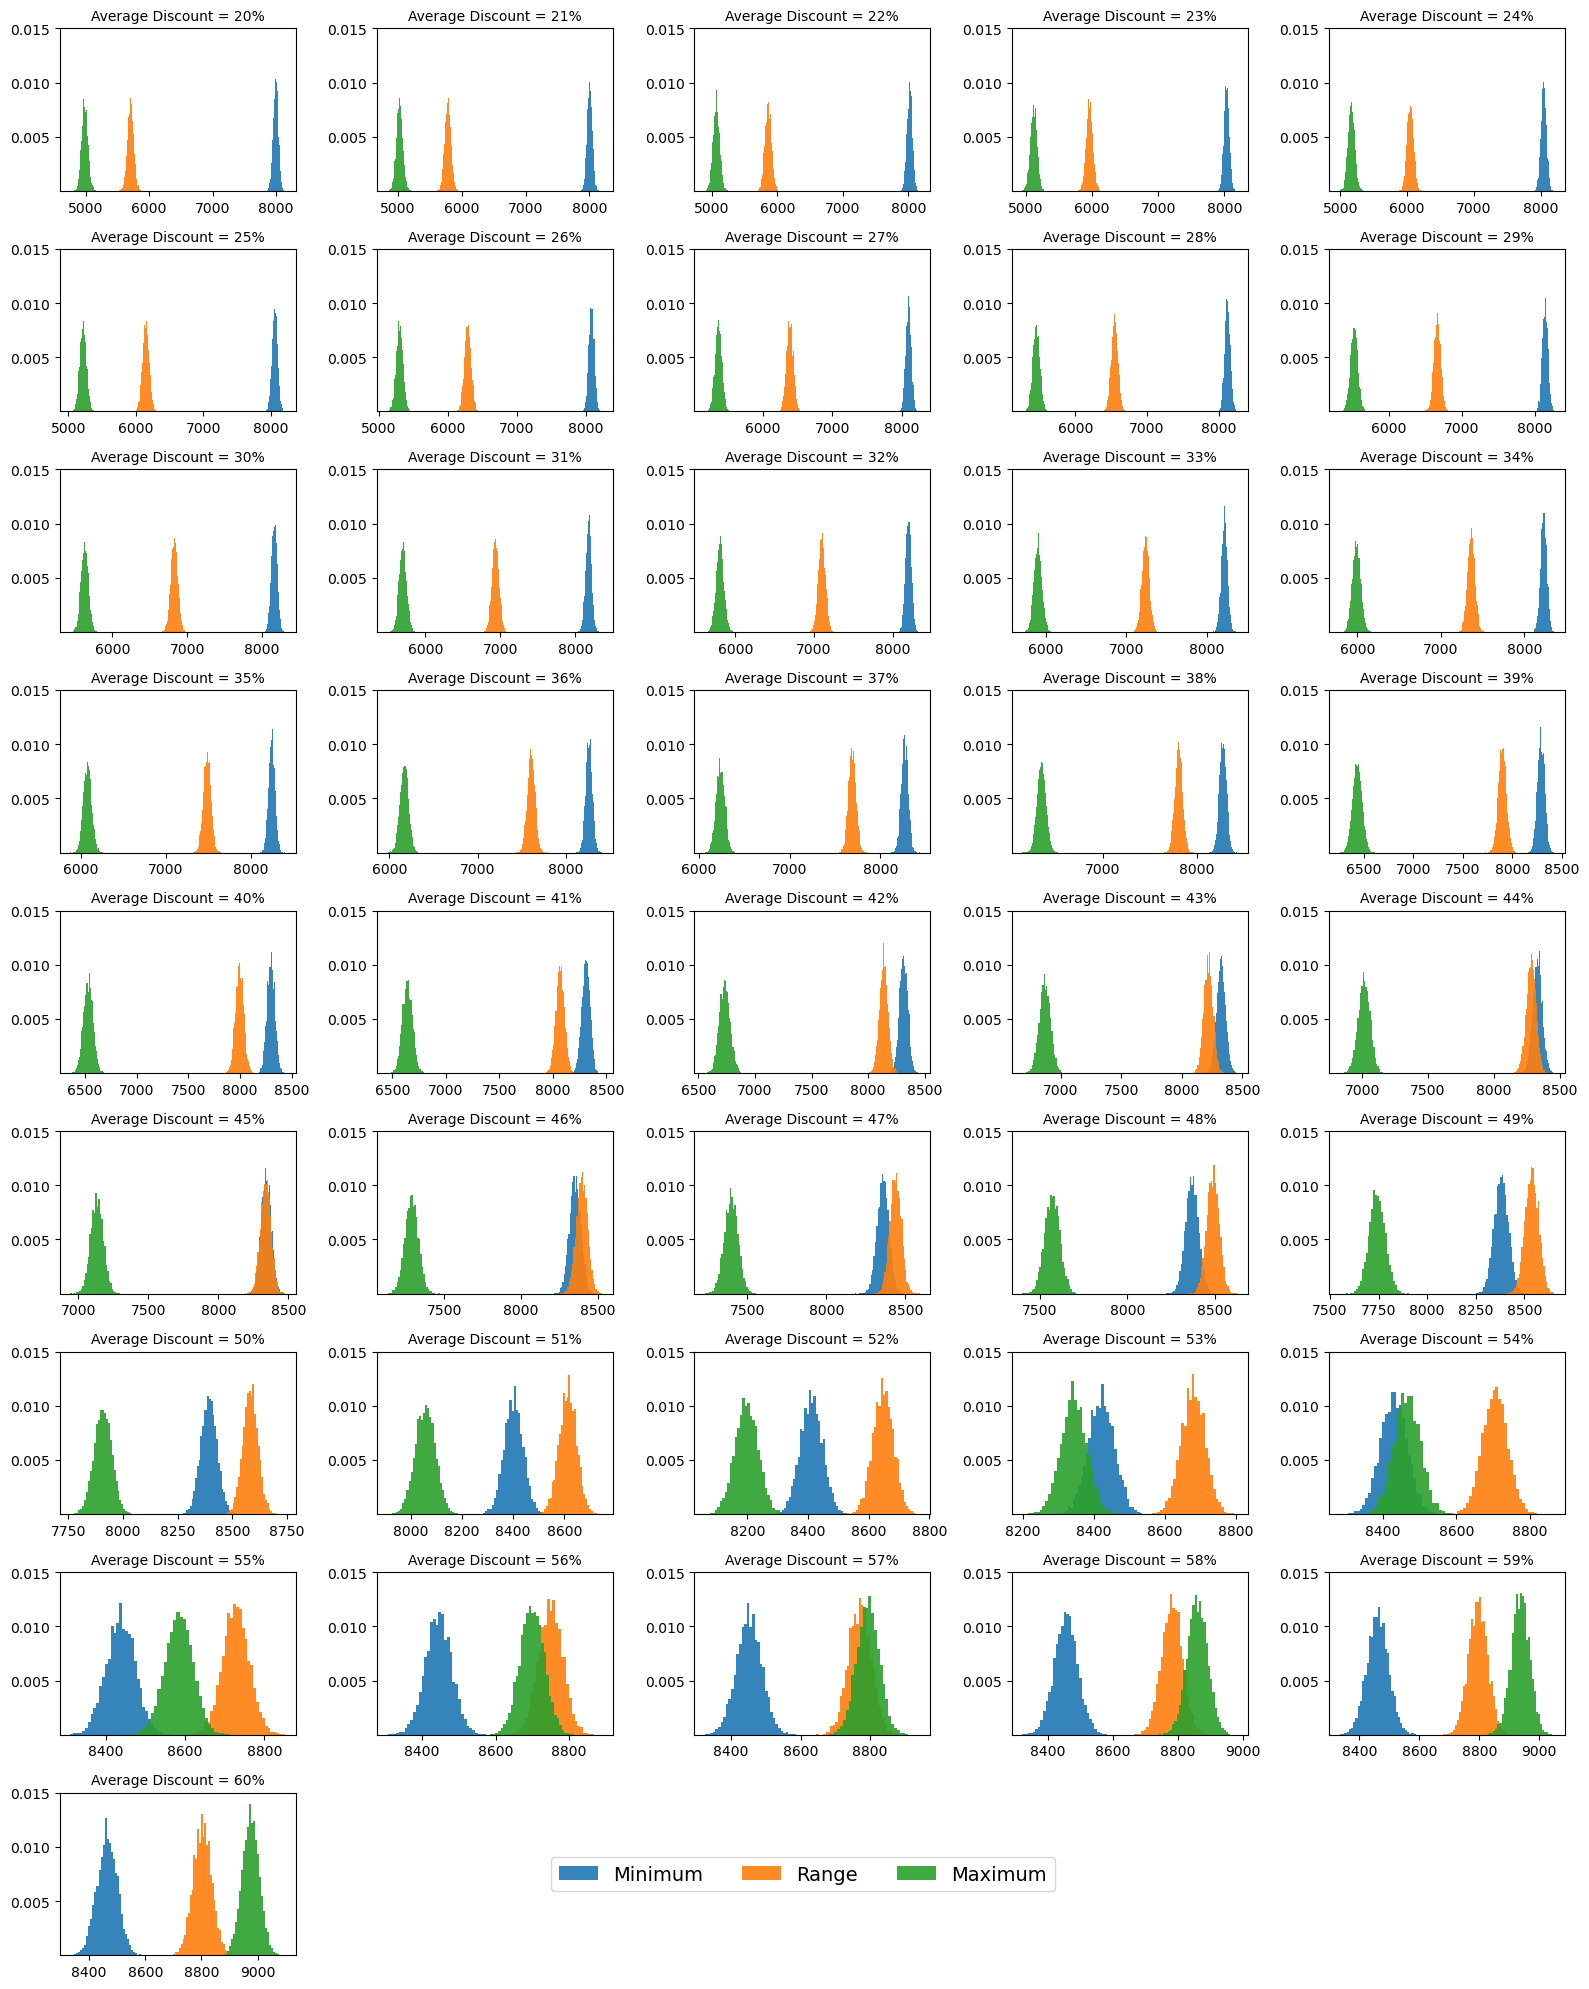

In [24]:
#fig

plt.rcdefaults()

fig = plt.figure(figsize=(16, 20))

for i in range(20,61):
    axis= fig.add_subplot(9,5,int('{}'.format(i-19)))
    axis.hist(Results.loc[Results.Discount==i,'Minimum'],bins=35, density=True,alpha=0.9)
    axis.hist(Results.loc[Results.Discount==i,'Range'],bins=35, density=True,alpha=0.9)
    axis.hist(Results.loc[Results.Discount==i,'Maximum'],bins=35, density=True,alpha=0.9)
    axis.set_yticks((0.005, 0.010,0.015))
    axis.set_yticklabels(("0.005", "0.010","0.015")) 
    axis.set_title('Average Discount = {}%'.format(i), fontsize=10)
    
fig.tight_layout()

plt.legend(["Minimum", "Range", "Maximum"], loc='center', bbox_to_anchor=(3.15, 0.5), fontsize=14, fancybox=True, ncol=3)

plt.show()

In [25]:
fig.savefig('build2_10000sims_dpi300density.png', dpi=300)

In [26]:
##discount censoring does not change mu too much.
Avgdiscounts=[]
for avgdiscount in range(20,61):
    overall=np.random.normal(avgdiscount, (category_max-category_min)/(3*2), assortment_size).round(0)
    overall=[i if 20<=i<=60 else 20 if i<20 else 60 for i in overall]
    Avgdiscounts.append(np.mean(overall))

In [27]:
Avgdiscounts

[22.6497,
 23.2302,
 23.7834,
 24.3935,
 25.1874,
 25.839,
 26.6957,
 27.5364,
 28.3636,
 29.1814,
 30.3123,
 31.1349,
 32.1409,
 33.104,
 34.0257,
 34.9108,
 36.128,
 37.1581,
 37.9747,
 38.9964,
 39.8994,
 41.0114,
 41.9128,
 43.0221,
 44.0471,
 44.9855,
 46.0003,
 46.9845,
 47.9409,
 48.8236,
 49.8445,
 50.6404,
 51.5977,
 52.4516,
 53.4322,
 54.1215,
 54.9,
 55.5766,
 56.2067,
 56.8625,
 57.3195]

In [29]:
np.random.normal(20, (category_max-category_min)/(3*2), assortment_size).round(0).mean()

20.0912